In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgbm

In [2]:
a = {'ma_lag': True, 'num_col_1': ['sell_price']}
NUM_COLS = CAT_COLS = []
for i, k in a.items():
    if "num_col_" in i:
        NUM_COLS += k

NUM_COLS

['sell_price']

In [3]:
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,5)

In [4]:
df = pd.read_pickle('./saved/data/preprocessed.pkl')
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,store_id_sold_lag28_ma28,dept_id_store_id_sold_lag28,dept_id_store_id_sold_lag28_ma7,dept_id_store_id_sold_lag28_ma28,cat_id_state_id_sold_lag28,cat_id_state_id_sold_lag28_ma7,cat_id_state_id_sold_lag28_ma28,sold_lag28,sold_lag28_ma7,sold_lag28_ma28
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1799,0.0,2016-01-01,11548,...,4069.071429,253.0,239.000000,247.500000,9773.0,9218.571429,9882.571429,38187.0,35539.428571,36817.714286
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1800,0.0,2016-01-02,11549,...,4064.500000,367.0,257.857143,248.035714,12172.0,9700.142857,9858.428571,47025.0,37369.857143,36806.428571
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1801,0.0,2016-01-03,11549,...,4055.678571,341.0,280.000000,250.357143,13253.0,10092.142857,9833.321429,48415.0,38888.857143,36806.571429
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1802,1.0,2016-01-04,11549,...,4062.535714,338.0,300.142857,255.500000,9725.0,10210.428571,9827.357143,35408.0,39373.428571,36752.750000
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1803,0.0,2016-01-05,11549,...,4049.392857,299.0,305.142857,258.964286,8852.0,10209.714286,9800.535714,32913.0,39101.285714,36736.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213272,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1965,NaN,2016-06-15,11620,...,4072.857143,133.0,155.285714,159.357143,2236.0,2641.000000,2697.678571,37096.0,45291.428571,43596.428571
5213273,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1966,NaN,2016-06-16,11620,...,4079.000000,141.0,158.142857,159.321429,2590.0,2683.714286,2704.785714,36963.0,44785.714286,43665.357143
5213274,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1967,NaN,2016-06-17,11620,...,4089.642857,230.0,167.571429,161.607143,2966.0,2724.142857,2706.464286,42552.0,44568.428571,43738.035714
5213275,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1968,NaN,2016-06-18,11621,...,4083.678571,218.0,169.428571,161.107143,3266.0,2683.714286,2700.571429,51518.0,44169.857143,43829.321429


In [5]:
# feature selection
target = 'sold'
num_cols = ['sell_price'] + [col for col in df.columns if 'sold_' in col]
cat_cols = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ['weekday','is_holiday','is_weekend']
# drop_cols = ['date','wm_yr_wk','d']

In [6]:
# Label encoding for lgbm
labels = {}
for col in cat_cols:
    df[col+'_encoded'] = df[col].astype('category')
    label = dict(zip(df[col+'_encoded'].cat.codes, df[col+'_encoded']))
    labels[col] = label
    df[col+'_encoded'] = df[col+'_encoded'].cat.codes

In [7]:
# train valid test split
df.loc[df.d<1914, 'train_valid_test'] = 'TRAIN'
df.loc[(df.d>=1914) & (df.d<1942), 'train_valid_test'] = 'VALID'
df.loc[df.d>=1942, 'train_valid_test'] = 'TEST'

X_train = df.loc[df.train_valid_test=='TRAIN', [col+'_encoded' for col in cat_cols] + num_cols]
X_valid = df.loc[df.train_valid_test=='VALID', [col+'_encoded' for col in cat_cols] + num_cols]
X_test = df.loc[df.train_valid_test=='TEST', [col+'_encoded' for col in cat_cols] + num_cols]

y_train = df.loc[df.train_valid_test=='TRAIN', target]
y_valid = df.loc[df.train_valid_test=='VALID', target]
y_test = df.loc[df.train_valid_test=='TEST', target]

print('Train: ',X_train.shape, y_train.shape, '\nValid: ', X_valid.shape, y_valid.shape, '\nTest: ',X_test.shape, y_test.shape)

Train:  (3505837, 30) (3505837,) 
Valid:  (853720, 30) (853720,) 
Test:  (853720, 30) (853720,)


In [84]:
valid_set = lgbm.Dataset(
    X_valid,
    y_valid,
    feature_name=[col + "_encoded" for col in CAT_COLS] + NUM_COLS,
    categorical_feature=[col + "_encoded" for col in CAT_COLS],
    params={'train_valid_test': 'VALID'}
)

test_set = lgbm.Dataset(
    X_test,
    y_test,
    feature_name=[col + "_encoded" for col in CAT_COLS] + NUM_COLS,
    categorical_feature=[col + "_encoded" for col in CAT_COLS],
    params={'train_valid_test': 'TEST'}
)

In [96]:
df = valid_set.data

for i,k in labels.items():
    df[i] = df[i+'_encoded'].replace(k)

In [99]:
[col for col in df.columns if "_encoded" not in col]

['sell_price',
 'id_sold_lag28',
 'id_sold_lag28_ma7',
 'id_sold_lag28_ma28',
 'item_id_sold_lag28',
 'item_id_sold_lag28_ma7',
 'item_id_sold_lag28_ma28',
 'cat_id_sold_lag28',
 'cat_id_sold_lag28_ma7',
 'cat_id_sold_lag28_ma28',
 'store_id_sold_lag28',
 'store_id_sold_lag28_ma7',
 'store_id_sold_lag28_ma28',
 'dept_id_store_id_sold_lag28',
 'dept_id_store_id_sold_lag28_ma7',
 'dept_id_store_id_sold_lag28_ma28',
 'cat_id_state_id_sold_lag28',
 'cat_id_state_id_sold_lag28_ma7',
 'cat_id_state_id_sold_lag28_ma28',
 'sold_lag28',
 'sold_lag28_ma7',
 'sold_lag28_ma28',
 'item_id',
 'dept_id',
 'store_id',
 'cat_id',
 'state_id',
 'weekday',
 'is_holiday',
 'is_weekend']

In [35]:
# LGBM training
train_set = lgbm.Dataset(
    X_train,
    y_train,
    feature_name = [col+'_encoded' for col in cat_cols] + num_cols,
    categorical_feature = [col+'_encoded' for col in cat_cols]
)

valid_set = lgbm.Dataset(
    X_valid,
    y_valid,
    feature_name = [col+'_encoded' for col in cat_cols] + num_cols,
    categorical_feature = [col+'_encoded' for col in cat_cols]
)

lgbm_params = {
    "objective" : "tweedie",
    "tweedie_variance_power": 1.25,
    "alpha" : 0.9,
    "metric" : ["rmse"],
    "force_row_wise" : True,
    "learning_rate" : 0.07,
    "bagging_freq" : 3,
    "bagging_fraction" : 0.5,
    "lambda_l2" : 0.1,
    "num_leaves" : 256,
    "min_data_in_leaf": 128,
    # 'max_depth': 10,
    # 'min_data_in_leaf': 50,
    # 'min_data_per_group': 10,
    # 'max_cat_threshold': 50,
    # 'max_cat_to_onehot': 106,
    # 'max_bin': 100,
    # 'min_data_in_bin': 10,
}

lgbm_trainer_args = {
    "num_boost_round": 1000,
    "early_stopping_rounds": 100,
    "verbose_eval": 50
}

lgbm_model = lgbm.train(
    lgbm_params,
    **lgbm_trainer_args,
    train_set=train_set,
    valid_sets=valid_set,
)

C:\Users\LAMRA2\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\LAMRA2\AppData\Roaming\Python\Python38\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\LAMRA2\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 8033
[LightGBM] [Info] Number of data points in the train set: 3505837, number of used features: 30


C:\Users\LAMRA2\AppData\Roaming\Python\Python38\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\LAMRA2\AppData\Roaming\Python\Python38\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.303852
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 2.22542
[100]	valid_0's rmse: 2.22292
[150]	valid_0's rmse: 2.22271
[200]	valid_0's rmse: 2.21894
[250]	valid_0's rmse: 2.21978
Early stopping, best iteration is:
[183]	valid_0's rmse: 2.21736


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

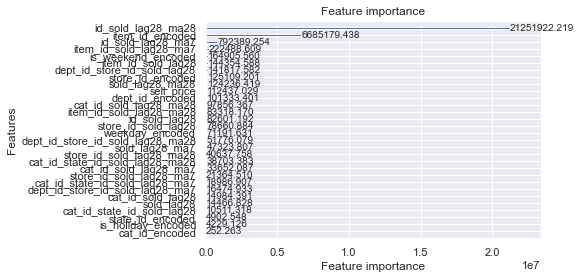

In [36]:
lgbm.plot_importance(lgbm_model, importance_type='gain')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

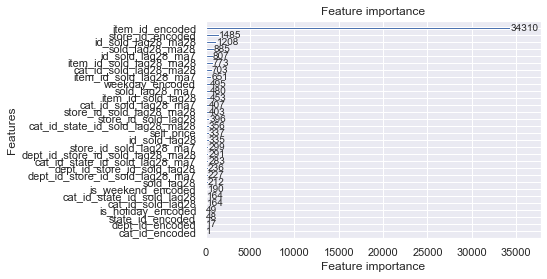

In [37]:
lgbm.plot_importance(lgbm_model, importance_type='split')

In [38]:
# predict
df[f'{target}_pred'] = lgbm_model.predict(df[[col+'_encoded' for col in cat_cols] + num_cols]).clip(min=0)

def wmape (y_pred, y):
    return np.sum(np.abs(y_pred - y))/np.sum(y)

# train & test wmape
# y_train_pred = lgbm_model.predict(X_train)
# y_valid_pred = lgbm_model.predict(X_valid)
# print(f"Train wmape: {wmape(y_train_pred, y_train)*100:.2f}%")
# print(f"Valid wmape: {wmape(y_valid_pred, y_valid)*100:.2f}%")

print(f"Train wmape: {wmape(df.loc[df.train_valid_test=='TRAIN', 'sold_pred'], y_train)*100:.2f}%")
print(f"Valid wmape: {wmape(df.loc[df.train_valid_test=='VALID', 'sold_pred'], y_valid)*100:.2f}%")


Train wmape: 67.93%
Valid wmape: 73.50%


In [39]:
df['error'] = np.abs(df.sold - df.sold_pred)
df[['train_valid_test','sold','sold_pred','error']].iloc[0:40]

,train_valid_test,sold,sold_pred,error
0,TRAIN,0.0,0.527405,0.527405
1,TRAIN,0.0,0.808869,0.808869
2,TRAIN,0.0,0.941992,0.941992
3,TRAIN,1.0,0.913058,0.086942
4,TRAIN,0.0,0.848268,0.848268
5,TRAIN,0.0,0.763896,0.763896
6,TRAIN,0.0,0.872088,0.872088
7,TRAIN,3.0,0.731214,2.268786
8,TRAIN,0.0,1.059038,1.059038
9,TRAIN,0.0,0.953888,0.953888
